In [1]:
#!pip3 install neat-python

from tensorflow.keras.datasets import mnist
import numpy as np
import ssl
import neat
from skimage.transform import rescale
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import math
import pickle

import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

## Global Parameters

In [2]:
# Dataset parameters
STANDARD_IMAGE_SIZE = 28
DESIRED_IMAGE_SIZE = 16
N_CLASSES_TO_USE = 10

RESCALE_FACTOR = DESIRED_IMAGE_SIZE/STANDARD_IMAGE_SIZE
N_PIXELS = DESIRED_IMAGE_SIZE**2

# How many samples to test:
N_SAMPLES_TO_TEST = 200

# Simulation Parameters
NR_GENERATIONS =1000
CONFIG_FILE = 'NEAT-configs/mnist-wann'

## Load MNIST

In [3]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


## Preprocess MNIST

### Trim down Dataset

In [4]:
# Ensure correct number of classes
X_train = X_train[Y_train < N_CLASSES_TO_USE]
Y_train = Y_train[Y_train < N_CLASSES_TO_USE]
X_test = X_test[Y_test < N_CLASSES_TO_USE]
Y_test = Y_test[Y_test < N_CLASSES_TO_USE]

# Extract and print the number of training and testing samples remaining
n_samples_train = X_train.shape[0]
n_samples_test = X_test.shape[0]
print(f"Training samples remaining: {n_samples_train}")
print(f"Testing samples remaining: {n_samples_test}")

Training samples remaining: 60000
Testing samples remaining: 10000


### Rescale Images

In [5]:
# Rescaling to the desired size
def rescale_images(images, do_anti_aliasing=False):
    return np.array([rescale(image, RESCALE_FACTOR, anti_aliasing=do_anti_aliasing) for image in images])

# Rescale X_train and X_test
X_train_small = rescale_images(X_train)
X_test_small = rescale_images(X_test)

### Normalize

In [6]:
# Normalize the data
def normalize(images):
    return (images - np.mean(images, axis=0))/(np.std(images, axis=0) + 0.000001)

# Normalize X_train_small and X_test_small
X_train_norm = normalize(X_train_small)
X_test_norm = normalize(X_test_small)

### Visualize

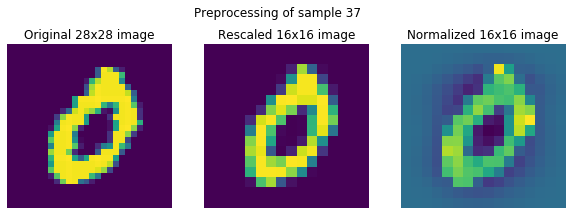

In [7]:
# Plot original and reshaped image
def plot_comparison(idx_to_plot, lists, titles):
    n_plots = len(lists)
    fig, ax = plt.subplots(1,n_plots, figsize=(10,10/n_plots))
    for i in range(n_plots):
        ax[i].imshow(lists[i][idx_to_plot])
        ax[i].set_title(titles[i])
        ax[i].axis("off")
    fig.suptitle(f"Preprocessing of sample {idx_to_plot}",y=1)
    plt.show()
    
plot_comparison(37,
                [X_train, X_train_small, X_train_norm],
                [f"Original {STANDARD_IMAGE_SIZE}x{STANDARD_IMAGE_SIZE} image",
                 f"Rescaled {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image",
                 f"Normalized {DESIRED_IMAGE_SIZE}x{DESIRED_IMAGE_SIZE} image"])

In [8]:
# Replace and reshape X_train and X_test, for convenience
X_train = X_train_norm.reshape(n_samples_train, DESIRED_IMAGE_SIZE**2)
X_test = X_test_norm.reshape(n_samples_test, DESIRED_IMAGE_SIZE**2)

# NEAT

## Basic Run Function

In [9]:
def exp(x):
    return np.exp(np.clip(x, -float('inf'), 709.))

# def sigmoid(output):
#     output = [min(709., x) for x in output]
#     output = [max(-709., x) for x in output]
#     return [1 /(1 + exp(-x)) for x in output]

def softmax(output):
    e = exp(output)
    return e / e.sum()

In [10]:
def step(x):
    return 1.0*(x>0.0)

def wann_cos(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return math.cos(math.pi*x)
    
def wann_sin(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return math.sin(math.pi * x)
        
def wann_sigmoid(x):
    x = max(-60.0, min(60.0, 5.0 * x))
    return (math.tanh(x/2.0) + 1.0)/2.0

def wann_inverse(x):
    return -x

def wann_gauss(x):
    x = max(-3.4, min(3.4, x))
    return exp(- (x*x) / 2.0)
        

def run(config_file):
    # Load configuration.
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    
    config.genome_config.add_activation('step', step)
    config.genome_config.add_activation('wcos', wann_cos)
    config.genome_config.add_activation('wsin', wann_sin)
    config.genome_config.add_activation('wsig', wann_sigmoid)
    config.genome_config.add_activation('winv', wann_inverse)
    config.genome_config.add_activation('wgauss', wann_gauss)
    
    
    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)
    
    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    
    p.add_reporter(stats)
    p.add_reporter(neat.Checkpointer(50, filename_prefix='NEAT-checkpoints/neat-checkpoint-10-classes-'))
    
    
    # Run for up to NR_GENERATIONS generations.
    winner = p.run(eval_genomes, NR_GENERATIONS)
    stats.save_genome_fitness(filename="NEAT-results/fitness_history.csv")
    stats.save_species_count(filename="NEAT-results/species_count.csv")
    with open('NEAT-results/best_genomes', 'wb') as f:
        best_genomes = stats.best_genomes(10)
        pickle.dump(best_genomes,f)
    
    
    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))


## Basic Evaluation Function

In [11]:
def eval_genomes(genomes, config):
    
    def _cross_entropy(pred, label):
        return -np.log(exp(pred[label])/np.sum(exp(pred), axis=0))
    
    sample_indices = []
    n_samples_per_class = int(N_SAMPLES_TO_TEST/N_CLASSES_TO_USE)
    for c in range(N_CLASSES_TO_USE):
        c_indices = np.where(Y_train == c)[0]
        assert len(c_indices) >= n_samples_per_class, \
            f"Class {c} has too few elements to reach the desired number of evaluation samples"
        sample_indices.extend(np.random.permutation(c_indices)[:n_samples_per_class])
    
    # Compute cross-entropy loss for each of the samples
    losses = []
    for i in sample_indices:
        X_sample, Y_sample = X_train[i], Y_train[i]
        
    
    for genome_id, genome in genomes:
        ce = []
        
        genome.fitness = 0.
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        nr_correct = 0.
        for i in sample_indices:
            train, label = X_train[i], Y_train[i]
            output = softmax(net.activate(train))
            
            ce.append(-_cross_entropy(output, label))
#             if np.argmax(sigmoid(output)) == label:
#                 nr_correct += 1.

        genome.fitness = np.average(ce)         
 

In [12]:
run(CONFIG_FILE)


 ****** Running generation 0 ****** 

Population's average fitness: -2.32362 stdev: 0.02483
Best fitness: -2.24663 - size: (10, 128) - species 1 - id 154
Average adjusted fitness: 0.055
Mean genetic distance 2.335, standard deviation 0.181
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0   250     -2.2    0.055     0
Total extinctions: 0
Generation time: 10.991 sec

 ****** Running generation 1 ****** 

Population's average fitness: -2.30975 stdev: 0.02716
Best fitness: -2.22489 - size: (10, 128) - species 1 - id 429
Average adjusted fitness: 0.070
Mean genetic distance 2.276, standard deviation 0.359
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1   250     -2.2    0.070     0
Total extinctions: 0
Generation time: 10.153 sec (10.572 average)

 ****** Running generation 2 ****** 

Population's average fitness: -2

Mean genetic distance 0.573, standard deviation 0.081
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   17   250     -2.2    0.077     5
Total extinctions: 0
Generation time: 10.435 sec (10.181 average)

 ****** Running generation 18 ****** 

Population's average fitness: -2.27638 stdev: 0.03117
Best fitness: -2.20608 - size: (11, 124) - species 1 - id 4515
Average adjusted fitness: 0.075
Mean genetic distance 0.561, standard deviation 0.075
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   18   250     -2.2    0.075     6
Total extinctions: 0
Generation time: 10.043 sec (10.186 average)

 ****** Running generation 19 ****** 

Population's average fitness: -2.27121 stdev: 0.03467
Best fitness: -2.18754 - size: (10, 128) - species 1 - id 4856
Average adjusted fitness: 0.092
Mean genetic distance 0.547, standard deviation 0.

Population's average fitness: -2.25252 stdev: 0.03923
Best fitness: -2.17754 - size: (13, 132) - species 1 - id 8890
Average adjusted fitness: 0.109
Mean genetic distance 0.707, standard deviation 0.098
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   35   250     -2.2    0.109     8
Total extinctions: 0
Generation time: 10.646 sec (10.460 average)

 ****** Running generation 36 ****** 

Population's average fitness: -2.24532 stdev: 0.04056
Best fitness: -2.15172 - size: (13, 132) - species 1 - id 9000
Average adjusted fitness: 0.112
Mean genetic distance 0.766, standard deviation 0.092
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   36   250     -2.2    0.112     9
Total extinctions: 0
Generation time: 10.481 sec (10.460 average)

 ****** Running generation 37 ****** 

Population's average fitness: -2.26772 stdev: 0.03

Mean genetic distance 0.737, standard deviation 0.151
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   52   250     -2.2    0.099    25
Total extinctions: 0
Generation time: 10.754 sec (10.643 average)

 ****** Running generation 53 ****** 

Population's average fitness: -2.24675 stdev: 0.04630
Best fitness: -2.14269 - size: (10, 116) - species 1 - id 13286
Average adjusted fitness: 0.119
Mean genetic distance 0.712, standard deviation 0.146
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   53   250     -2.1    0.119     0
Total extinctions: 0
Generation time: 10.550 sec (10.623 average)

 ****** Running generation 54 ****** 

Population's average fitness: -2.24874 stdev: 0.04118
Best fitness: -2.16565 - size: (10, 114) - species 1 - id 13633
Average adjusted fitness: 0.144
Mean genetic distance 0.635, standard deviation 

Population's average fitness: -2.24384 stdev: 0.04077
Best fitness: -2.15091 - size: (13, 115) - species 1 - id 17575
Average adjusted fitness: 0.116
Mean genetic distance 0.698, standard deviation 0.118
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   70   250     -2.2    0.116     9
Total extinctions: 0
Generation time: 10.025 sec (10.123 average)

 ****** Running generation 71 ****** 

Population's average fitness: -2.24390 stdev: 0.04347
Best fitness: -2.15390 - size: (11, 121) - species 1 - id 17778
Average adjusted fitness: 0.120
Mean genetic distance 0.656, standard deviation 0.132
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   71   250     -2.2    0.120    10
Total extinctions: 0
Generation time: 10.257 sec (10.120 average)

 ****** Running generation 72 ****** 

Population's average fitness: -2.24313 stdev: 0.

Population's average fitness: -2.23107 stdev: 0.04732
Best fitness: -2.13257 - size: (10, 108) - species 1 - id 21882
Average adjusted fitness: 0.119
Mean genetic distance 0.695, standard deviation 0.187
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   88   250     -2.1    0.119    27
Total extinctions: 0
Generation time: 10.226 sec (10.007 average)
Saving checkpoint to NEAT-checkpoints/neat-checkpoint-10-classes-88

 ****** Running generation 89 ****** 

Population's average fitness: -2.22936 stdev: 0.04658
Best fitness: -2.13325 - size: (14, 115) - species 1 - id 22157
Average adjusted fitness: 0.110
Mean genetic distance 0.781, standard deviation 0.209
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1   89   250     -2.1    0.110    28
Total extinctions: 0
Generation time: 10.009 sec (9.992 average)

 ****** Running gene

Population's average fitness: -2.20802 stdev: 0.05305
Best fitness: -2.10333 - size: (10, 106) - species 1 - id 26493
Average adjusted fitness: 0.159
Mean genetic distance 0.732, standard deviation 0.240
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  106   250     -2.1    0.159    14
Total extinctions: 0
Generation time: 9.891 sec (10.035 average)

 ****** Running generation 107 ****** 

Population's average fitness: -2.22006 stdev: 0.04288
Best fitness: -2.12609 - size: (10, 101) - species 1 - id 26779
Average adjusted fitness: 0.142
Mean genetic distance 0.701, standard deviation 0.200
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  107   250     -2.1    0.142    15
Total extinctions: 0
Generation time: 9.747 sec (9.967 average)

 ****** Running generation 108 ****** 

Population's average fitness: -2.22871 stdev: 0.0

Population's average fitness: -2.21822 stdev: 0.05090
Best fitness: -2.11594 - size: (12, 105) - species 1 - id 30084
Average adjusted fitness: 0.121
Mean genetic distance 0.594, standard deviation 0.103
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  124   250     -2.1    0.121     6
Total extinctions: 0
Generation time: 9.934 sec (9.871 average)

 ****** Running generation 125 ****** 

Population's average fitness: -2.20571 stdev: 0.05465
Best fitness: -2.09255 - size: (11, 102) - species 1 - id 30756
Average adjusted fitness: 0.156
Mean genetic distance 0.560, standard deviation 0.085
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  125   250     -2.1    0.156     7
Total extinctions: 0
Generation time: 9.809 sec (9.853 average)

 ****** Running generation 126 ****** 

Population's average fitness: -2.22048 stdev: 0.04

Population's average fitness: -2.21200 stdev: 0.04646
Best fitness: -2.09670 - size: (12, 100) - species 1 - id 34780
Average adjusted fitness: 0.113
Mean genetic distance 0.869, standard deviation 0.097
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  142   250     -2.1    0.113     4
Total extinctions: 0
Generation time: 9.942 sec (9.754 average)

 ****** Running generation 143 ****** 

Population's average fitness: -2.21904 stdev: 0.04648
Best fitness: -2.11231 - size: (11, 100) - species 1 - id 35633
Average adjusted fitness: 0.119
Mean genetic distance 0.908, standard deviation 0.115
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  143   250     -2.1    0.119     5
Total extinctions: 0
Generation time: 9.688 sec (9.736 average)

 ****** Running generation 144 ****** 

Population's average fitness: -2.22056 stdev: 0.04

Population's average fitness: -2.22143 stdev: 0.05014
Best fitness: -2.12717 - size: (11, 98) - species 1 - id 39347
Average adjusted fitness: 0.119
Mean genetic distance 0.602, standard deviation 0.110
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  160   250     -2.1    0.119    14
Total extinctions: 0
Generation time: 9.429 sec (9.701 average)

 ****** Running generation 161 ****** 

Population's average fitness: -2.23018 stdev: 0.04827
Best fitness: -2.12835 - size: (11, 98) - species 1 - id 39347
Average adjusted fitness: 0.125
Mean genetic distance 0.572, standard deviation 0.101
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  161   250     -2.1    0.125    15
Total extinctions: 0
Generation time: 9.443 sec (9.626 average)

 ****** Running generation 162 ****** 

Population's average fitness: -2.20339 stdev: 0.0554

Population's average fitness: -2.21251 stdev: 0.04652
Best fitness: -2.10470 - size: (11, 98) - species 1 - id 43777
Average adjusted fitness: 0.143
Mean genetic distance 0.654, standard deviation 0.119
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  178   250     -2.1    0.143    32
Total extinctions: 0
Generation time: 9.877 sec (9.750 average)

 ****** Running generation 179 ****** 

Population's average fitness: -2.22117 stdev: 0.04664
Best fitness: -2.12185 - size: (15, 109) - species 1 - id 44458
Average adjusted fitness: 0.121
Mean genetic distance 0.685, standard deviation 0.114
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  179   250     -2.1    0.121    33
Total extinctions: 0
Generation time: 9.982 sec (9.779 average)

 ****** Running generation 180 ****** 

Population's average fitness: -2.22623 stdev: 0.041

Population's average fitness: -2.21041 stdev: 0.05001
Best fitness: -2.11459 - size: (20, 115) - species 1 - id 48478
Average adjusted fitness: 0.134
Mean genetic distance 0.949, standard deviation 0.179
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  196   250     -2.1    0.134     5
Total extinctions: 0
Generation time: 10.558 sec (10.261 average)

 ****** Running generation 197 ****** 

Population's average fitness: -2.20532 stdev: 0.05009
Best fitness: -2.08069 - size: (16, 106) - species 1 - id 48997
Average adjusted fitness: 0.130
Mean genetic distance 0.855, standard deviation 0.179
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  197   250     -2.1    0.130     6
Total extinctions: 0
Generation time: 10.655 sec (10.313 average)

 ****** Running generation 198 ****** 

Population's average fitness: -2.20875 stdev: 

Mean genetic distance 1.226, standard deviation 0.124
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  213   250     -2.1    0.135     3
Total extinctions: 0
Generation time: 11.451 sec (10.866 average)

 ****** Running generation 214 ****** 

Population's average fitness: -2.20978 stdev: 0.05139
Best fitness: -2.08139 - size: (17, 108) - species 1 - id 53245
Average adjusted fitness: 0.150
Mean genetic distance 1.230, standard deviation 0.118
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  214   250     -2.1    0.150     4
Total extinctions: 0
Generation time: 11.419 sec (10.954 average)

 ****** Running generation 215 ****** 

Population's average fitness: -2.19896 stdev: 0.05147
Best fitness: -2.08555 - size: (17, 108) - species 1 - id 53245
Average adjusted fitness: 0.147
Mean genetic distance 1.118, standard deviatio

Population's average fitness: -2.19985 stdev: 0.05179
Best fitness: -2.08995 - size: (15, 98) - species 1 - id 57339
Average adjusted fitness: 0.129
Mean genetic distance 1.302, standard deviation 0.269
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  231   250     -2.1    0.129     3
Total extinctions: 0
Generation time: 11.120 sec (11.257 average)

 ****** Running generation 232 ****** 

Population's average fitness: -2.19837 stdev: 0.05126
Best fitness: -2.08554 - size: (19, 107) - species 1 - id 57588
Average adjusted fitness: 0.158
Mean genetic distance 1.101, standard deviation 0.305
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  232   250     -2.1    0.158     4
Total extinctions: 0
Generation time: 11.238 sec (11.276 average)

 ****** Running generation 233 ****** 

Population's average fitness: -2.20698 stdev: 0

Population's average fitness: -2.19843 stdev: 0.05266
Best fitness: -2.09078 - size: (17, 101) - species 1 - id 61080
Average adjusted fitness: 0.145
Mean genetic distance 0.955, standard deviation 0.188
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  249   250     -2.1    0.145    21
Total extinctions: 0
Generation time: 11.517 sec (11.389 average)

 ****** Running generation 250 ****** 

Population's average fitness: -2.18419 stdev: 0.05453
Best fitness: -2.06626 - size: (17, 101) - species 1 - id 61080
Average adjusted fitness: 0.131
Mean genetic distance 1.031, standard deviation 0.220
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  250   250     -2.1    0.131    22
Total extinctions: 0
Generation time: 11.349 sec (11.410 average)

 ****** Running generation 251 ****** 

Population's average fitness: -2.19508 stdev: 

Mean genetic distance 0.710, standard deviation 0.232
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  266   250     -2.1    0.152    38
Total extinctions: 0
Generation time: 10.799 sec (11.032 average)

 ****** Running generation 267 ****** 

Population's average fitness: -2.18812 stdev: 0.05913
Best fitness: -2.07269 - size: (19, 111) - species 1 - id 66220
Average adjusted fitness: 0.156
Mean genetic distance 0.730, standard deviation 0.208
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  267   250     -2.1    0.156    39
Total extinctions: 0
Generation time: 10.651 sec (10.981 average)

 ****** Running generation 268 ****** 

Population's average fitness: -2.19258 stdev: 0.05675
Best fitness: -2.08882 - size: (15, 104) - species 1 - id 66348
Average adjusted fitness: 0.133
Mean genetic distance 0.783, standard deviatio

Population's average fitness: -2.21448 stdev: 0.04633
Best fitness: -2.12189 - size: (20, 107) - species 1 - id 70630
Average adjusted fitness: 0.131
Mean genetic distance 0.754, standard deviation 0.112
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  284   250     -2.1    0.131     9
Total extinctions: 0
Generation time: 10.040 sec (10.297 average)

 ****** Running generation 285 ****** 

Population's average fitness: -2.21141 stdev: 0.04867
Best fitness: -2.11763 - size: (10, 86) - species 1 - id 70829
Average adjusted fitness: 0.142
Mean genetic distance 0.742, standard deviation 0.133
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  285   250     -2.1    0.142    10
Total extinctions: 0
Generation time: 10.218 sec (10.263 average)

 ****** Running generation 286 ****** 

Population's average fitness: -2.20966 stdev: 0

Mean genetic distance 0.853, standard deviation 0.263
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  301   250     -2.1    0.157    26
Total extinctions: 0
Generation time: 9.933 sec (10.181 average)

 ****** Running generation 302 ****** 

Population's average fitness: -2.20163 stdev: 0.04785
Best fitness: -2.09315 - size: (21, 103) - species 1 - id 75041
Average adjusted fitness: 0.136
Mean genetic distance 0.955, standard deviation 0.269
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  302   250     -2.1    0.136    27
Total extinctions: 0
Generation time: 10.058 sec (10.128 average)

 ****** Running generation 303 ****** 

Population's average fitness: -2.22396 stdev: 0.04322
Best fitness: -2.14009 - size: (22, 111) - species 1 - id 74961
Average adjusted fitness: 0.129
Mean genetic distance 1.101, standard deviation

Population's average fitness: -2.21714 stdev: 0.04433
Best fitness: -2.12942 - size: (22, 107) - species 1 - id 79127
Average adjusted fitness: 0.138
Mean genetic distance 0.909, standard deviation 0.162
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  319   250     -2.1    0.138    44
Total extinctions: 0
Generation time: 11.551 sec (11.476 average)

 ****** Running generation 320 ****** 

Population's average fitness: -2.20030 stdev: 0.05352
Best fitness: -2.10107 - size: (22, 107) - species 1 - id 79127
Average adjusted fitness: 0.132
Mean genetic distance 0.961, standard deviation 0.142
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  320   250     -2.1    0.132    45
Total extinctions: 0
Generation time: 11.785 sec (11.462 average)
Saving checkpoint to NEAT-checkpoints/neat-checkpoint-10-classes-320

 ****** Running g

Mean genetic distance 0.936, standard deviation 0.233
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  336   250     -2.1    0.152    61
Total extinctions: 0
Generation time: 11.192 sec (11.001 average)

 ****** Running generation 337 ****** 

Population's average fitness: -2.21430 stdev: 0.05487
Best fitness: -2.09432 - size: (17, 97) - species 1 - id 83764
Average adjusted fitness: 0.137
Mean genetic distance 0.951, standard deviation 0.236
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  337   250     -2.1    0.137    62
Total extinctions: 0
Generation time: 10.968 sec (11.021 average)

 ****** Running generation 338 ****** 

Population's average fitness: -2.20808 stdev: 0.04819
Best fitness: -2.09202 - size: (18, 101) - species 1 - id 83676
Average adjusted fitness: 0.156
Mean genetic distance 0.988, standard deviation

Population's average fitness: -2.19565 stdev: 0.04898
Best fitness: -2.07126 - size: (22, 98) - species 1 - id 86599
Average adjusted fitness: 0.152
Mean genetic distance 0.732, standard deviation 0.193
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  354   250     -2.1    0.152    15
Total extinctions: 0
Generation time: 10.585 sec (10.823 average)

 ****** Running generation 355 ****** 

Population's average fitness: -2.19230 stdev: 0.05662
Best fitness: -2.06109 - size: (21, 94) - species 1 - id 87876
Average adjusted fitness: 0.149
Mean genetic distance 0.761, standard deviation 0.203
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  355   250     -2.1    0.149    16
Total extinctions: 0
Generation time: 10.243 sec (10.752 average)

 ****** Running generation 356 ****** 

Population's average fitness: -2.17479 stdev: 0.

Population's average fitness: -2.18442 stdev: 0.05871
Best fitness: -2.05469 - size: (16, 88) - species 1 - id 92002
Average adjusted fitness: 0.161
Mean genetic distance 0.783, standard deviation 0.137
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  372   250     -2.1    0.161     9
Total extinctions: 0
Generation time: 10.691 sec (10.366 average)

 ****** Running generation 373 ****** 

Population's average fitness: -2.20260 stdev: 0.05377
Best fitness: -2.07784 - size: (16, 88) - species 1 - id 92002
Average adjusted fitness: 0.135
Mean genetic distance 0.743, standard deviation 0.120
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  373   250     -2.1    0.135    10
Total extinctions: 0
Generation time: 10.428 sec (10.351 average)

 ****** Running generation 374 ****** 

Population's average fitness: -2.19596 stdev: 0.

Mean genetic distance 0.930, standard deviation 0.349
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  389   250     -2.1    0.137    26
Total extinctions: 0
Generation time: 10.589 sec (10.478 average)

 ****** Running generation 390 ****** 

Population's average fitness: -2.17479 stdev: 0.05766
Best fitness: -2.02069 - size: (22, 98) - species 1 - id 95390
Average adjusted fitness: 0.166
Mean genetic distance 0.845, standard deviation 0.332
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  390   250     -2.0    0.166    27
Total extinctions: 0
Generation time: 10.242 sec (10.466 average)

 ****** Running generation 391 ****** 

Population's average fitness: -2.19562 stdev: 0.05282
Best fitness: -2.06054 - size: (22, 100) - species 1 - id 96395
Average adjusted fitness: 0.147
Mean genetic distance 0.804, standard deviation


 ****** Running generation 407 ****** 

Population's average fitness: -2.18860 stdev: 0.05171
Best fitness: -2.06555 - size: (20, 88) - species 1 - id 98594
Average adjusted fitness: 0.128
Mean genetic distance 0.768, standard deviation 0.105
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  407   250     -2.1    0.128    44
Total extinctions: 0
Generation time: 10.766 sec (10.960 average)

 ****** Running generation 408 ****** 

Population's average fitness: -2.18398 stdev: 0.05442
Best fitness: -2.05461 - size: (20, 88) - species 1 - id 98594
Average adjusted fitness: 0.170
Mean genetic distance 0.805, standard deviation 0.113
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  408   250     -2.1    0.170    45
Total extinctions: 0
Generation time: 10.708 sec (10.947 average)

 ****** Running generation 409 ****** 

Populat

Population's average fitness: -2.18713 stdev: 0.05530
Best fitness: -2.05854 - size: (21, 91) - species 1 - id 104588
Average adjusted fitness: 0.175
Mean genetic distance 1.029, standard deviation 0.196
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  425   250     -2.1    0.175    13
Total extinctions: 0
Generation time: 10.881 sec (10.643 average)

 ****** Running generation 426 ****** 

Population's average fitness: -2.18157 stdev: 0.05328
Best fitness: -2.05515 - size: (20, 90) - species 1 - id 105730
Average adjusted fitness: 0.139
Mean genetic distance 0.981, standard deviation 0.187
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  426   250     -2.1    0.139    14
Total extinctions: 0
Generation time: 10.548 sec (10.603 average)

 ****** Running generation 427 ****** 

Population's average fitness: -2.18921 stdev: 

Mean genetic distance 1.190, standard deviation 0.292
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  442   250     -2.1    0.143    30
Total extinctions: 0
Generation time: 11.330 sec (11.030 average)

 ****** Running generation 443 ****** 

Population's average fitness: -2.18794 stdev: 0.05259
Best fitness: -2.05235 - size: (20, 95) - species 1 - id 109246
Average adjusted fitness: 0.126
Mean genetic distance 1.141, standard deviation 0.343
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  443   250     -2.1    0.126    31
Total extinctions: 0
Generation time: 10.994 sec (11.053 average)

 ****** Running generation 444 ****** 

Population's average fitness: -2.17886 stdev: 0.06447
Best fitness: -2.01984 - size: (24, 98) - species 1 - id 110333
Average adjusted fitness: 0.149
Mean genetic distance 1.165, standard deviatio

Population's average fitness: -2.20738 stdev: 0.05786
Best fitness: -2.06808 - size: (20, 95) - species 1 - id 109246
Average adjusted fitness: 0.158
Mean genetic distance 0.891, standard deviation 0.254
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  460   250     -2.1    0.158    48
Total extinctions: 0
Generation time: 11.799 sec (11.299 average)

 ****** Running generation 461 ****** 

Population's average fitness: -2.19323 stdev: 0.04903
Best fitness: -2.05201 - size: (20, 95) - species 1 - id 109246
Average adjusted fitness: 0.135
Mean genetic distance 0.983, standard deviation 0.243
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  461   250     -2.1    0.135    49
Total extinctions: 0
Generation time: 11.698 sec (11.364 average)

 ****** Running generation 462 ****** 

Population's average fitness: -2.19220 stdev: 

Population's average fitness: -2.18811 stdev: 0.05640
Best fitness: -2.05607 - size: (20, 95) - species 1 - id 109246
Average adjusted fitness: 0.126
Mean genetic distance 1.098, standard deviation 0.381
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  478   250     -2.1    0.126    66
Total extinctions: 0
Generation time: 10.425 sec (10.736 average)

 ****** Running generation 479 ****** 

Population's average fitness: -2.19245 stdev: 0.05039
Best fitness: -2.08506 - size: (20, 95) - species 1 - id 109246
Average adjusted fitness: 0.132
Mean genetic distance 0.795, standard deviation 0.226
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  479   250     -2.1    0.132    67
Total extinctions: 0
Generation time: 10.676 sec (10.694 average)

 ****** Running generation 480 ****** 

Population's average fitness: -2.18781 stdev: 

Mean genetic distance 0.785, standard deviation 0.356
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  495   250     -2.0    0.155    83
Total extinctions: 0
Generation time: 11.064 sec (10.750 average)

 ****** Running generation 496 ****** 

Population's average fitness: -2.19505 stdev: 0.04878
Best fitness: -2.08971 - size: (21, 92) - species 1 - id 123058
Average adjusted fitness: 0.146
Mean genetic distance 0.742, standard deviation 0.301
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  496   250     -2.1    0.146    84
Total extinctions: 0
Generation time: 10.857 sec (10.766 average)

 ****** Running generation 497 ****** 

Population's average fitness: -2.15967 stdev: 0.06191
Best fitness: -2.02572 - size: (17, 90) - species 1 - id 123444
Average adjusted fitness: 0.170
Mean genetic distance 0.821, standard deviatio

Population's average fitness: -2.18317 stdev: 0.05006
Best fitness: -2.05989 - size: (19, 88) - species 1 - id 124650
Average adjusted fitness: 0.167
Mean genetic distance 1.022, standard deviation 0.322
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  513   250     -2.1    0.167     1
Total extinctions: 0
Generation time: 10.605 sec (10.668 average)

 ****** Running generation 514 ****** 

Population's average fitness: -2.18683 stdev: 0.05284
Best fitness: -2.06070 - size: (19, 88) - species 1 - id 124650
Average adjusted fitness: 0.130
Mean genetic distance 0.972, standard deviation 0.336
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  514   250     -2.1    0.130     2
Total extinctions: 0
Generation time: 10.448 sec (10.649 average)

 ****** Running generation 515 ****** 

Population's average fitness: -2.17214 stdev: 

Mean genetic distance 0.633, standard deviation 0.284
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  530   250     -2.1    0.148    14
Total extinctions: 0
Generation time: 10.728 sec (10.508 average)

 ****** Running generation 531 ****** 

Population's average fitness: -2.17736 stdev: 0.05013
Best fitness: -2.05521 - size: (22, 90) - species 1 - id 131547
Average adjusted fitness: 0.152
Mean genetic distance 0.674, standard deviation 0.320
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  531   250     -2.1    0.152    15
Total extinctions: 0
Generation time: 10.561 sec (10.532 average)

 ****** Running generation 532 ****** 

Population's average fitness: -2.18182 stdev: 0.05539
Best fitness: -2.05162 - size: (23, 96) - species 1 - id 132129
Average adjusted fitness: 0.149
Mean genetic distance 0.676, standard deviatio

Population's average fitness: -2.17559 stdev: 0.05708
Best fitness: -2.05373 - size: (23, 98) - species 1 - id 136057
Average adjusted fitness: 0.162
Mean genetic distance 1.019, standard deviation 0.225
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  548   250     -2.1    0.162    32
Total extinctions: 0
Generation time: 11.614 sec (11.281 average)

 ****** Running generation 549 ****** 

Population's average fitness: -2.18679 stdev: 0.05192
Best fitness: -2.07311 - size: (23, 98) - species 1 - id 136057
Average adjusted fitness: 0.136
Mean genetic distance 1.011, standard deviation 0.226
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  549   250     -2.1    0.136    33
Total extinctions: 0
Generation time: 11.411 sec (11.306 average)

 ****** Running generation 550 ****** 

Population's average fitness: -2.17937 stdev: 

Mean genetic distance 1.206, standard deviation 0.332
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  565   250     -2.0    0.154    49
Total extinctions: 0
Generation time: 11.862 sec (11.619 average)

 ****** Running generation 566 ****** 

Population's average fitness: -2.17623 stdev: 0.05333
Best fitness: -2.04056 - size: (26, 102) - species 1 - id 138257
Average adjusted fitness: 0.193
Mean genetic distance 0.977, standard deviation 0.308
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  566   250     -2.0    0.193    50
Total extinctions: 0
Generation time: 11.799 sec (11.688 average)

 ****** Running generation 567 ****** 

Population's average fitness: -2.16504 stdev: 0.05716
Best fitness: -2.01661 - size: (26, 102) - species 1 - id 138257
Average adjusted fitness: 0.159
Mean genetic distance 0.939, standard deviat

Population's average fitness: -2.19554 stdev: 0.04924
Best fitness: -2.06867 - size: (22, 97) - species 1 - id 144479
Average adjusted fitness: 0.111
Mean genetic distance 0.814, standard deviation 0.160
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  583   250     -2.1    0.111    67
Total extinctions: 0
Generation time: 11.560 sec (11.629 average)

 ****** Running generation 584 ****** 

Population's average fitness: -2.18856 stdev: 0.05153
Best fitness: -2.05228 - size: (22, 97) - species 1 - id 144479
Average adjusted fitness: 0.148
Mean genetic distance 0.842, standard deviation 0.145
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  584   250     -2.1    0.148    68
Total extinctions: 0
Generation time: 11.499 sec (11.620 average)

 ****** Running generation 585 ****** 

Population's average fitness: -2.20619 stdev: 

Population's average fitness: -2.16861 stdev: 0.05373
Best fitness: -2.03174 - size: (25, 94) - species 1 - id 145680
Average adjusted fitness: 0.188
Mean genetic distance 0.722, standard deviation 0.245
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  601   250     -2.0    0.188    85
Total extinctions: 0
Generation time: 11.369 sec (11.105 average)

 ****** Running generation 602 ****** 

Population's average fitness: -2.19397 stdev: 0.05015
Best fitness: -2.08059 - size: (23, 88) - species 1 - id 149419
Average adjusted fitness: 0.142
Mean genetic distance 0.695, standard deviation 0.201
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  602   250     -2.1    0.142    86
Total extinctions: 0
Generation time: 11.239 sec (11.111 average)

 ****** Running generation 603 ****** 

Population's average fitness: -2.17824 stdev: 

Mean genetic distance 0.991, standard deviation 0.125
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  618   250     -2.1    0.154     3
Total extinctions: 0
Generation time: 11.233 sec (11.000 average)

 ****** Running generation 619 ****** 

Population's average fitness: -2.18641 stdev: 0.05645
Best fitness: -2.04956 - size: (21, 87) - species 1 - id 153548
Average adjusted fitness: 0.167
Mean genetic distance 1.014, standard deviation 0.113
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  619   250     -2.0    0.167     4
Total extinctions: 0
Generation time: 11.141 sec (11.036 average)

 ****** Running generation 620 ****** 

Population's average fitness: -2.17012 stdev: 0.05315
Best fitness: -2.04572 - size: (21, 87) - species 1 - id 153548
Average adjusted fitness: 0.168
Mean genetic distance 1.022, standard deviatio

Population's average fitness: -2.17970 stdev: 0.05537
Best fitness: -2.05927 - size: (20, 83) - species 1 - id 157095
Average adjusted fitness: 0.135
Mean genetic distance 0.943, standard deviation 0.170
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  636   250     -2.1    0.135    21
Total extinctions: 0
Generation time: 10.740 sec (10.698 average)

 ****** Running generation 637 ****** 

Population's average fitness: -2.17990 stdev: 0.05332
Best fitness: -2.04981 - size: (26, 94) - species 1 - id 157642
Average adjusted fitness: 0.157
Mean genetic distance 0.930, standard deviation 0.190
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  637   250     -2.0    0.157    22
Total extinctions: 0
Generation time: 10.728 sec (10.734 average)

 ****** Running generation 638 ****** 

Population's average fitness: -2.18476 stdev: 

Mean genetic distance 0.608, standard deviation 0.100
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  653   250     -2.0    0.179    38
Total extinctions: 0
Generation time: 10.953 sec (11.202 average)

 ****** Running generation 654 ****** 

Population's average fitness: -2.17298 stdev: 0.05334
Best fitness: -2.04693 - size: (22, 88) - species 1 - id 162410
Average adjusted fitness: 0.131
Mean genetic distance 0.649, standard deviation 0.097
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  654   250     -2.0    0.131    39
Total extinctions: 0
Generation time: 10.696 sec (11.196 average)
Saving checkpoint to NEAT-checkpoints/neat-checkpoint-10-classes-654

 ****** Running generation 655 ****** 

Population's average fitness: -2.17883 stdev: 0.05864
Best fitness: -2.05400 - size: (22, 88) - species 1 - id 162410
Average a

Population's average fitness: -2.17543 stdev: 0.05277
Best fitness: -2.02745 - size: (21, 85) - species 1 - id 166174
Average adjusted fitness: 0.158
Mean genetic distance 0.679, standard deviation 0.233
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  671   250     -2.0    0.158    56
Total extinctions: 0
Generation time: 11.492 sec (11.216 average)

 ****** Running generation 672 ****** 

Population's average fitness: -2.16464 stdev: 0.06090
Best fitness: -2.01511 - size: (21, 85) - species 1 - id 166174
Average adjusted fitness: 0.176
Mean genetic distance 0.698, standard deviation 0.208
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  672   250     -2.0    0.176    57
Total extinctions: 0
Generation time: 11.123 sec (11.214 average)

 ****** Running generation 673 ****** 

Population's average fitness: -2.18372 stdev: 

Population's average fitness: -2.19630 stdev: 0.05023
Best fitness: -2.05562 - size: (22, 86) - species 1 - id 170601
Average adjusted fitness: 0.132
Mean genetic distance 1.102, standard deviation 0.127
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  689   250     -2.1    0.132    74
Total extinctions: 0
Generation time: 11.654 sec (11.496 average)

 ****** Running generation 690 ****** 

Population's average fitness: -2.18798 stdev: 0.05347
Best fitness: -2.04769 - size: (22, 86) - species 1 - id 170601
Average adjusted fitness: 0.138
Mean genetic distance 0.917, standard deviation 0.248
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  690   250     -2.0    0.138    75
Total extinctions: 0
Generation time: 11.575 sec (11.522 average)

 ****** Running generation 691 ****** 

Population's average fitness: -2.21219 stdev: 

Mean genetic distance 0.781, standard deviation 0.118
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  706   250     -2.1    0.135    91
Total extinctions: 0
Generation time: 11.350 sec (11.466 average)

 ****** Running generation 707 ****** 

Population's average fitness: -2.17126 stdev: 0.05646
Best fitness: -2.00360 - size: (22, 82) - species 1 - id 172621
Average adjusted fitness: 0.143
Mean genetic distance 0.757, standard deviation 0.150
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  707   250     -2.0    0.143    92
Total extinctions: 0
Generation time: 11.191 sec (11.409 average)

 ****** Running generation 708 ****** 

Population's average fitness: -2.19113 stdev: 0.04905
Best fitness: -2.08641 - size: (23, 84) - species 1 - id 175602
Average adjusted fitness: 0.121
Mean genetic distance 0.701, standard deviatio

Population's average fitness: -2.16180 stdev: 0.05713
Best fitness: -2.00847 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.137
Mean genetic distance 0.949, standard deviation 0.308
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  724   250     -2.0    0.137   109
Total extinctions: 0
Generation time: 11.254 sec (11.222 average)

 ****** Running generation 725 ****** 

Population's average fitness: -2.18381 stdev: 0.05319
Best fitness: -2.04291 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.135
Mean genetic distance 0.944, standard deviation 0.287
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  725   250     -2.0    0.135   110
Total extinctions: 0
Generation time: 11.552 sec (11.241 average)

 ****** Running generation 726 ****** 

Population's average fitness: -2.17194 stdev: 

Mean genetic distance 0.923, standard deviation 0.395
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  741   250     -2.0    0.161   126
Total extinctions: 0
Generation time: 11.120 sec (11.150 average)

 ****** Running generation 742 ****** 

Population's average fitness: -2.18963 stdev: 0.04868
Best fitness: -2.05728 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.136
Mean genetic distance 0.883, standard deviation 0.366
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  742   250     -2.1    0.136   127
Total extinctions: 0
Generation time: 11.210 sec (11.165 average)

 ****** Running generation 743 ****** 

Population's average fitness: -2.16885 stdev: 0.05618
Best fitness: -2.01147 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.141
Mean genetic distance 1.003, standard deviatio

Population's average fitness: -2.19259 stdev: 0.05535
Best fitness: -2.03294 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.131
Mean genetic distance 1.445, standard deviation 0.186
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  759   250     -2.0    0.131   144
Total extinctions: 0
Generation time: 11.240 sec (11.119 average)

 ****** Running generation 760 ****** 

Population's average fitness: -2.17804 stdev: 0.05592
Best fitness: -2.02833 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.152
Mean genetic distance 1.442, standard deviation 0.185
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  760   250     -2.0    0.152   145
Total extinctions: 0
Generation time: 11.108 sec (11.142 average)

 ****** Running generation 761 ****** 

Population's average fitness: -2.18406 stdev: 

Mean genetic distance 1.330, standard deviation 0.580
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  776   250     -2.1    0.143   161
Total extinctions: 0
Generation time: 10.982 sec (10.763 average)

 ****** Running generation 777 ****** 

Population's average fitness: -2.17412 stdev: 0.05943
Best fitness: -2.01386 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.197
Mean genetic distance 1.138, standard deviation 0.602
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  777   250     -2.0    0.197   162
Total extinctions: 0
Generation time: 10.930 sec (10.795 average)

 ****** Running generation 778 ****** 

Population's average fitness: -2.19187 stdev: 0.05318
Best fitness: -2.07397 - size: (22, 83) - species 1 - id 193033
Average adjusted fitness: 0.141
Mean genetic distance 1.142, standard deviatio

Population's average fitness: -2.18434 stdev: 0.05742
Best fitness: -2.03239 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.176
Mean genetic distance 0.725, standard deviation 0.507
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  794   250     -2.0    0.176     3
Total extinctions: 0
Generation time: 11.377 sec (11.003 average)

 ****** Running generation 795 ****** 

Population's average fitness: -2.17752 stdev: 0.05711
Best fitness: -2.02618 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.154
Mean genetic distance 0.674, standard deviation 0.425
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  795   250     -2.0    0.154     4
Total extinctions: 0
Generation time: 11.296 sec (11.049 average)

 ****** Running generation 796 ****** 

Population's average fitness: -2.17278 stdev: 

Population's average fitness: -2.18631 stdev: 0.05431
Best fitness: -2.05160 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.135
Mean genetic distance 0.595, standard deviation 0.135
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  812   250     -2.1    0.135    21
Total extinctions: 0
Generation time: 11.359 sec (11.425 average)

 ****** Running generation 813 ****** 

Population's average fitness: -2.20461 stdev: 0.04629
Best fitness: -2.09667 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.111
Mean genetic distance 0.575, standard deviation 0.150
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  813   250     -2.1    0.111    22
Total extinctions: 0
Generation time: 11.496 sec (11.453 average)

 ****** Running generation 814 ****** 

Population's average fitness: -2.18219 stdev: 

Mean genetic distance 0.695, standard deviation 0.255
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  829   250     -2.0    0.131    38
Total extinctions: 0
Generation time: 11.735 sec (11.741 average)

 ****** Running generation 830 ****** 

Population's average fitness: -2.18638 stdev: 0.05313
Best fitness: -2.05296 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.141
Mean genetic distance 0.687, standard deviation 0.254
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  830   250     -2.1    0.141    39
Total extinctions: 0
Generation time: 11.408 sec (11.720 average)

 ****** Running generation 831 ****** 

Population's average fitness: -2.18607 stdev: 0.05468
Best fitness: -2.03617 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.146
Mean genetic distance 0.701, standard deviatio

Population's average fitness: -2.19464 stdev: 0.05351
Best fitness: -2.05198 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.144
Mean genetic distance 0.542, standard deviation 0.114
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  847   250     -2.1    0.144    56
Total extinctions: 0
Generation time: 11.460 sec (11.437 average)

 ****** Running generation 848 ****** 

Population's average fitness: -2.17952 stdev: 0.05925
Best fitness: -2.02985 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.157
Mean genetic distance 0.553, standard deviation 0.098
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  848   250     -2.0    0.157    57
Total extinctions: 0
Generation time: 11.653 sec (11.466 average)

 ****** Running generation 849 ****** 

Population's average fitness: -2.19310 stdev: 

Mean genetic distance 0.717, standard deviation 0.188
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  864   250     -2.0    0.128    73
Total extinctions: 0
Generation time: 11.769 sec (11.572 average)

 ****** Running generation 865 ****** 

Population's average fitness: -2.19447 stdev: 0.05505
Best fitness: -2.04077 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.140
Mean genetic distance 0.764, standard deviation 0.176
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  865   250     -2.0    0.140    74
Total extinctions: 0
Generation time: 11.789 sec (11.629 average)

 ****** Running generation 866 ****** 

Population's average fitness: -2.18154 stdev: 0.05534
Best fitness: -2.02098 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.139
Mean genetic distance 0.818, standard deviatio

Population's average fitness: -2.17788 stdev: 0.05720
Best fitness: -2.00225 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.141
Mean genetic distance 0.802, standard deviation 0.171
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  882   250     -2.0    0.141     2
Total extinctions: 0
Generation time: 11.505 sec (11.382 average)

 ****** Running generation 883 ****** 

Population's average fitness: -2.18782 stdev: 0.05731
Best fitness: -2.03182 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.142
Mean genetic distance 0.798, standard deviation 0.189
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  883   250     -2.0    0.142     3
Total extinctions: 0
Generation time: 11.429 sec (11.395 average)

 ****** Running generation 884 ****** 

Population's average fitness: -2.18555 stdev: 

Population's average fitness: -2.19242 stdev: 0.05810
Best fitness: -2.03880 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.149
Mean genetic distance 0.644, standard deviation 0.194
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  900   250     -2.0    0.149    20
Total extinctions: 0
Generation time: 11.847 sec (11.552 average)

 ****** Running generation 901 ****** 

Population's average fitness: -2.19848 stdev: 0.05197
Best fitness: -2.06583 - size: (22, 89) - species 1 - id 178873
Average adjusted fitness: 0.151
Mean genetic distance 0.616, standard deviation 0.199
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  901   250     -2.1    0.151    21
Total extinctions: 0
Generation time: 11.386 sec (11.552 average)

 ****** Running generation 902 ****** 

Population's average fitness: -2.18805 stdev: 

Mean genetic distance 0.650, standard deviation 0.214
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  917   250     -2.0    0.182    37
Total extinctions: 0
Generation time: 10.889 sec (11.189 average)

 ****** Running generation 918 ****** 

Population's average fitness: -2.19161 stdev: 0.05333
Best fitness: -2.04941 - size: (22, 86) - species 1 - id 224444
Average adjusted fitness: 0.155
Mean genetic distance 0.633, standard deviation 0.182
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  918   250     -2.0    0.155    38
Total extinctions: 0
Generation time: 10.510 sec (11.100 average)

 ****** Running generation 919 ****** 

Population's average fitness: -2.18511 stdev: 0.05459
Best fitness: -2.02456 - size: (22, 86) - species 1 - id 224444
Average adjusted fitness: 0.147
Mean genetic distance 0.666, standard deviatio

Population's average fitness: -2.18129 stdev: 0.05374
Best fitness: -2.03075 - size: (22, 86) - species 1 - id 224444
Average adjusted fitness: 0.147
Mean genetic distance 0.616, standard deviation 0.194
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  935   250     -2.0    0.147    55
Total extinctions: 0
Generation time: 10.629 sec (10.418 average)

 ****** Running generation 936 ****** 

Population's average fitness: -2.18180 stdev: 0.05831
Best fitness: -2.02533 - size: (22, 86) - species 1 - id 224444
Average adjusted fitness: 0.147
Mean genetic distance 0.688, standard deviation 0.218
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  936   250     -2.0    0.147    56
Total extinctions: 0
Generation time: 10.443 sec (10.418 average)

 ****** Running generation 937 ****** 

Population's average fitness: -2.20261 stdev: 

Mean genetic distance 0.566, standard deviation 0.167
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  952   250     -2.0    0.160    72
Total extinctions: 0
Generation time: 11.261 sec (10.881 average)

 ****** Running generation 953 ****** 

Population's average fitness: -2.17948 stdev: 0.05417
Best fitness: -2.03868 - size: (22, 86) - species 1 - id 224444
Average adjusted fitness: 0.168
Mean genetic distance 0.555, standard deviation 0.165
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  953   250     -2.0    0.168    73
Total extinctions: 0
Generation time: 10.954 sec (10.911 average)

 ****** Running generation 954 ****** 

Population's average fitness: -2.19454 stdev: 0.05653
Best fitness: -2.06252 - size: (22, 86) - species 1 - id 224444
Average adjusted fitness: 0.131
Mean genetic distance 0.567, standard deviatio

Population's average fitness: -2.17958 stdev: 0.04937
Best fitness: -2.03829 - size: (22, 86) - species 1 - id 230752
Average adjusted fitness: 0.127
Mean genetic distance 0.592, standard deviation 0.152
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  970   250     -2.0    0.127    90
Total extinctions: 0
Generation time: 11.212 sec (10.680 average)

 ****** Running generation 971 ****** 

Population's average fitness: -2.18683 stdev: 0.05793
Best fitness: -2.03634 - size: (22, 86) - species 1 - id 230752
Average adjusted fitness: 0.182
Mean genetic distance 0.608, standard deviation 0.164
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  971   250     -2.0    0.182    91
Total extinctions: 0
Generation time: 10.800 sec (10.703 average)

 ****** Running generation 972 ****** 

Population's average fitness: -2.17907 stdev: 

Population's average fitness: -2.17845 stdev: 0.05564
Best fitness: -2.02493 - size: (22, 86) - species 1 - id 230752
Average adjusted fitness: 0.153
Mean genetic distance 0.677, standard deviation 0.173
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  988   250     -2.0    0.153   108
Total extinctions: 0
Generation time: 10.742 sec (10.973 average)

 ****** Running generation 989 ****** 

Population's average fitness: -2.19537 stdev: 0.04847
Best fitness: -2.07028 - size: (22, 86) - species 1 - id 230752
Average adjusted fitness: 0.132
Mean genetic distance 0.736, standard deviation 0.172
Population of 250 members in 1 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1  989   250     -2.1    0.132   109
Total extinctions: 0
Generation time: 10.617 sec (10.826 average)

 ****** Running generation 990 ****** 

Population's average fitness: -2.19032 stdev: 

## Plot History

In [13]:
history = np.genfromtxt('NEAT-results/fitness_history.csv', delimiter='')
best_fitness = history[:,0]
avg_fitness = history[:,1]

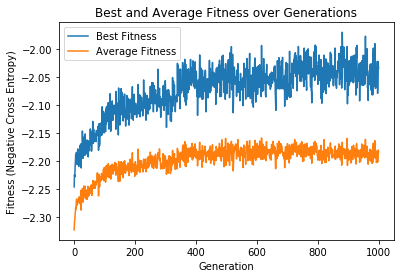

In [14]:
plt.plot(best_fitness, label = 'Best Fitness')
plt.plot(avg_fitness, label = 'Average Fitness')
plt.title('Best and Average Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Fitness (Negative Cross Entropy)')
plt.legend()
plt.show()

## Load and Test Fittest Member

In [17]:
def test_fittest(config_file):
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)
    config.genome_config.add_activation('step', step)
    config.genome_config.add_activation('wcos', wann_cos)
    config.genome_config.add_activation('wsin', wann_sin)
    config.genome_config.add_activation('wsig', wann_sigmoid)
    config.genome_config.add_activation('winv', wann_inverse)
    config.genome_config.add_activation('wgauss', wann_gauss)
    preds_test = []
    preds_train = []
    train_correct = 0.
    test_correct = 0. 
    fittest_genome = pickle.load( open('NEAT-results/best_genomes', 'rb'))[0]
    #print(fittest_genome)
    net = neat.nn.FeedForwardNetwork.create(fittest_genome, config)
        
    for train, label in zip(X_train, Y_train):
        output = np.argmax(softmax(net.activate(train)))
        preds_train.append(output)
        if output == label:
            train_correct += 1.
    train_acc = train_correct / len(X_train)
    
    for test, label in zip(X_test, Y_test):
        output = np.argmax(softmax(net.activate(test)))
        preds_test.append(output)
        if output == label:
            test_correct += 1.
    test_acc = test_correct / len(X_test)
        
    print("Train Accuracy = {}".format(train_acc))
    print("Test Accuracy = {}".format(test_acc))
    
    return preds_train, preds_test

In [18]:
preds_train, preds_test = test_fittest(CONFIG_FILE)

Train Accuracy = 0.4507333333333333
Test Accuracy = 0.4527


In [19]:
cm_train = confusion_matrix(Y_train, preds_train, labels=range(N_CLASSES_TO_USE))
cm_test = confusion_matrix(Y_test, preds_test, labels=range(N_CLASSES_TO_USE))

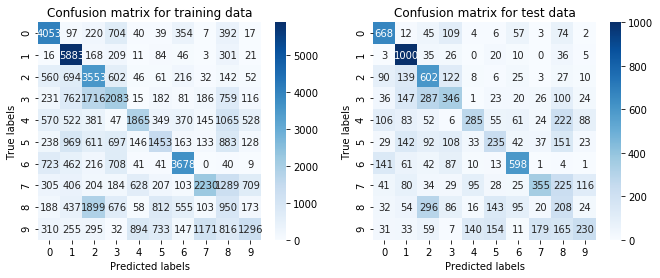

In [20]:
# Create figure
fig, ax = plt.subplots(1,2, figsize=(11,4))

# Plot confusion matrix for training data
sns.heatmap(cm_train, annot=True, fmt='g', ax=ax[0], cmap="Blues")
ax[0].set_xlabel('Predicted labels')
ax[0].set_ylabel('True labels')
ax[0].set_title('Confusion matrix for training data')

# Plot confusion matrix for validation data
sns.heatmap(cm_test, annot=True, fmt='g', ax=ax[1], cmap="Blues")
ax[1].set_xlabel('Predicted labels')
ax[1].set_ylabel('True labels')
ax[1].set_title('Confusion matrix for test data')

# Show the result
plt.show()

## Inspecting Fittest Genome

In [21]:
fittest_genome = pickle.load( open('NEAT-results/best_genomes', 'rb'))[0]

In [22]:
print(fittest_genome)

Key: 178873
Fitness: -1.9695472747268445
Nodes:
	0 DefaultNodeGene(key=0, bias=0.0, response=1.0, activation=relu, aggregation=sum)
	1 DefaultNodeGene(key=1, bias=0.0, response=1.0, activation=winv, aggregation=sum)
	2 DefaultNodeGene(key=2, bias=0.0, response=1.0, activation=identity, aggregation=sum)
	3 DefaultNodeGene(key=3, bias=0.0, response=1.0, activation=identity, aggregation=sum)
	4 DefaultNodeGene(key=4, bias=0.0, response=1.0, activation=identity, aggregation=sum)
	5 DefaultNodeGene(key=5, bias=0.0, response=1.0, activation=identity, aggregation=sum)
	6 DefaultNodeGene(key=6, bias=0.0, response=1.0, activation=relu, aggregation=sum)
	7 DefaultNodeGene(key=7, bias=0.0, response=1.0, activation=relu, aggregation=sum)
	8 DefaultNodeGene(key=8, bias=0.0, response=1.0, activation=identity, aggregation=sum)
	9 DefaultNodeGene(key=9, bias=0.0, response=1.0, activation=relu, aggregation=sum)
	25710 DefaultNodeGene(key=25710, bias=0.0, response=1.0, activation=tanh, aggregation=sum)


In [23]:
used_input_pixels = []
for cg in fittest_genome.connections.values():
    if cg.enabled:
        used_input_pixels.append(cg.key[0])
print(used_input_pixels)

[-212, -120, -206, -30, -57, -249, -234, -185, -138, -201, -103, -242, -156, -167, -132, -79, -125, -184, -154, -170, -140, -22, -247, -241, -87, -87, -92, -85, -141, -235, -50, -181, -204, -119, -49, -134, -52, -28, -97, -231, -152, -54, -161, -129, 25710, -4, -114, -132, -170, -254, -42, -85, -250, -125, -219, -170, -21, -146, -254, -129, -248, 37969, 39788, -85, 40287, -161, -198, -199, -218, -22, 41505, 37969, 41575, -125, 43337, -20, -141, 40287, -218, 43640, 8, 5, -201, 43950, -134, 44051, -108, -248, 44306]


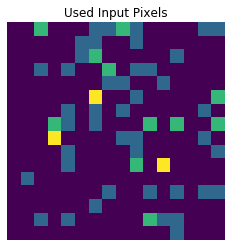

In [24]:
input_tallies = np.zeros(X_train.shape[1])
for arg in used_input_pixels:
    if arg <0:
        input_tallies[arg] += 1
plt.imshow( input_tallies.reshape(16,16) )
plt.title('Used Input Pixels')
plt.axis('off')
plt.show()